In [54]:
import pandas as pd
from editdistance import eval as ed
import numpy as np
from address_compare.crf_tagger import AddressTagger
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
%pylab inline
import re
from sklearn import naive_bayes

ADDRESS_COLS = ["STREET_NUMBER", "PRE_DIRECTION", "STREET_NAME", "STREET_TYPE", "POST_DIRECTION",
                "UNIT_TYPE", "UNIT_NUMBER"]
DIST_COLS = ["STREET_NUMBER", "STREET_NAME", "UNIT_NUMBER"]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def digit_extract(s):
    re_digit_extract = re.compile('(^\d+$|\d+(?=st|nd|rd|th|ST|ND|RD|TH))')
    d = re_digit_extract.search(s)
    return d.group() if d is not None else ''

def series_ed(s1: pd.Series, s2: pd.Series):
    '''
    vectorizes edit distance over two pandas series
    :param s1: series of strings
    :param s2: series of strings
    :return: series of numbers
    '''
    df = pd.concat([s1, s2], axis=1)
    df.columns = ['a', 'b']
    return pd.concat([s1, s2], axis=1).apply(lambda x: ed(x[0], x[1]), axis=1, raw = True)

def edit_distance_matrix(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in DIST_COLS:
        out[col+'DIST'] = series_ed(df1[col], df2[col])
    return out

def equal_features(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in ADDRESS_COLS:
        out[col+'_EQUAL'] = df1[col] == df2[col]
    return out

def number_mod_text(s1, s2):
    if (s1 == s2):
        return True
    d1 = digit_extract(s1)
    if d1:
        d2 = digit_extract(s2)
        return d1 == d2
    return False

def number_mod_text_series(s1, s2):
    return pd.concat([s1, s2], 1).apply(lambda x: number_mod_text(x[0], x[1]), 1, raw = True)

Populating the interactive namespace from numpy and matplotlib


In [55]:
from statsmodels.api import Logit
at = AddressTagger()

In [56]:
from address_compare.address_randomizer import random_addresses2
full_data = random_addresses2(50)
full_data

,address_1,address_2,match
0,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180 AVE,True
1,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180th AVE,True
2,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180 AVE,True
3,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180th AVE,True
4,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180 AVE",True
5,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180th AVE",True
6,"#1195, 98141 NE 180 AVE","98141 NE 180 AVE, BLDG 1195",True
7,"#1195, 98141 NE 180 AVE","98141 NE 180th AVE, BLDG 1195",True
8,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180 AVE,True
9,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180th AVE,True


In [57]:
ad1 = at.series_to_address_df(full_data['address_1'], standardize=True)
ad2 = at.series_to_address_df(full_data['address_2'], standardize=True)
features = pd.concat([edit_distance_matrix(ad1, ad2), equal_features(ad1, ad2)], axis = 1)
features['STREET_MOD_TEXT_EQUAL'] = number_mod_text_series(ad1['STREET_NAME'], ad2['STREET_NAME'])
features['const'] = 1
features = features.applymap(int)
train = np.random.binomial(1, .7, full_data.shape[0]) == 1
features.corr()

,STREET_NUMBERDIST,STREET_NAMEDIST,UNIT_NUMBERDIST,STREET_NUMBER_EQUAL,PRE_DIRECTION_EQUAL,STREET_NAME_EQUAL,STREET_TYPE_EQUAL,POST_DIRECTION_EQUAL,UNIT_TYPE_EQUAL,UNIT_NUMBER_EQUAL,STREET_MOD_TEXT_EQUAL,const
STREET_NUMBERDIST,1.000,0.309,0.733,-0.910,-0.372,-0.137,-0.486,-0.322,-0.278,-0.478,-0.317,nan
STREET_NAMEDIST,0.309,1.000,0.166,-0.303,-0.288,-0.656,-0.417,-0.237,-0.230,-0.348,-0.557,nan
UNIT_NUMBERDIST,0.733,0.166,1.000,-0.632,-0.146,-0.124,-0.193,-0.103,-0.327,-0.681,-0.237,nan
STREET_NUMBER_EQUAL,-0.910,-0.303,-0.632,1.000,0.344,0.131,0.450,0.311,0.237,0.414,0.318,nan
PRE_DIRECTION_EQUAL,-0.372,-0.288,-0.146,0.344,1.000,0.143,0.381,0.477,0.093,0.173,0.346,nan
STREET_NAME_EQUAL,-0.137,-0.656,-0.124,0.131,0.143,1.000,0.224,0.117,0.245,0.403,0.596,nan
STREET_TYPE_EQUAL,-0.486,-0.417,-0.193,0.450,0.381,0.224,1.000,0.297,0.176,0.245,0.455,nan
POST_DIRECTION_EQUAL,-0.322,-0.237,-0.103,0.311,0.477,0.117,0.297,1.000,0.068,0.114,0.305,nan
UNIT_TYPE_EQUAL,-0.278,-0.230,-0.327,0.237,0.093,0.245,0.176,0.068,1.000,0.422,0.294,nan
UNIT_NUMBER_EQUAL,-0.478,-0.348,-0.681,0.414,0.173,0.403,0.245,0.114,0.422,1.000,0.528,nan


In [58]:
f = Logit(full_data[train]['match'], features[train])
f = f.fit()

Optimization terminated successfully.
         Current function value: 0.340104
         Iterations 8


In [59]:
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  match   No. Observations:                 1292
Model:                          Logit   Df Residuals:                     1280
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Dec 2017   Pseudo R-squ.:                  0.4802
Time:                        23:59:09   Log-Likelihood:                -439.41
converged:                       True   LL-Null:                       -845.29
                                        LLR p-value:                5.668e-167
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
STREET_NUMBERDIST         0.8940      0.159      5.630      0.000       0.583       1.205
STREET_NAMEDIST          -0.3914      0.070     -5.587      0.000      -0.529      -0.254
UNIT_NUMBERDIST           0.3756      0.143      2.625      0.009       0.095       0.656
STREET_NUMBER_EQUAL       5.9932      0.606      9.882      0.000       4.805       7.182
PRE_DIRECTION_EQUAL       1.6762      0.375      4.468      0.000       0.941       2.412
STREET_NAME_EQUAL        -2.4915      0.342     -7.279      0.000      -3.162      -1.821
STREET_TYPE_EQUAL         3.5762      0.384      9.325      0.000       2.825       4.328
POST_DIRECTION_EQUAL      2.1560      0.370      5.830      0.000       1.431       2.881
UNIT_TYPE_EQUAL          -0.9189      0.197     -4.654      0.000      -1.306      -0.532
UNIT_NUMBER_EQUAL         2.3004      0.315      7.305      0.000       1.683       2.918
STREET_MOD_TEXT_EQUAL     0.6631      0.279      2.379      0.017       0.117       1.209
const                   -11.2329      0.922    -12.188      0.000     -13.039      -9.426
=========================================================================================
"""

In [60]:
full_data['prob'] = f.predict(features)

In [61]:
full_data

,address_1,address_2,match,prob
0,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180 AVE,True,0.933
1,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180th AVE,True,0.987
2,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180 AVE,True,0.933
3,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180th AVE,True,0.987
4,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180 AVE",True,0.933
5,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180th AVE",True,0.987
6,"#1195, 98141 NE 180 AVE","98141 NE 180 AVE, BLDG 1195",True,0.933
7,"#1195, 98141 NE 180 AVE","98141 NE 180th AVE, BLDG 1195",True,0.987
8,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180 AVE,True,0.354
9,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180th AVE,True,0.752


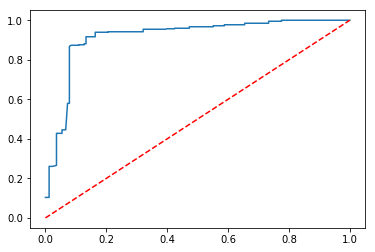

In [62]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [63]:
roc_auc_score(full_data[~train]['match'], full_data[~train]['prob'])

0.91685462217107794

In [64]:
pd.concat([full_data, features], 1)[88:89]

,address_1,address_2,match,prob,STREET_NUMBERDIST,STREET_NAMEDIST,UNIT_NUMBERDIST,STREET_NUMBER_EQUAL,PRE_DIRECTION_EQUAL,STREET_NAME_EQUAL,STREET_TYPE_EQUAL,POST_DIRECTION_EQUAL,UNIT_TYPE_EQUAL,UNIT_NUMBER_EQUAL,STREET_MOD_TEXT_EQUAL,const
88,"#C, 61189 A BLVD",APT C - 61189 A BLVD,True,0.933,0,0,0,1,1,1,1,1,0,1,1,1


In [65]:
nb1 = naive_bayes.BernoulliNB()
nb1.fit(X=features[train], y=full_data[train]['match'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [66]:
full_data['nb1'] = nb1.predict_proba(features)[:,1]
full_data

,address_1,address_2,match,prob,nb1
0,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180 AVE,True,0.933,0.993
1,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180th AVE,True,0.987,0.987
2,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180 AVE,True,0.933,0.993
3,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180th AVE,True,0.987,0.987
4,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180 AVE",True,0.933,0.993
5,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180th AVE",True,0.987,0.987
6,"#1195, 98141 NE 180 AVE","98141 NE 180 AVE, BLDG 1195",True,0.933,0.993
7,"#1195, 98141 NE 180 AVE","98141 NE 180th AVE, BLDG 1195",True,0.987,0.987
8,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180 AVE,True,0.354,0.128
9,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180th AVE,True,0.752,0.078


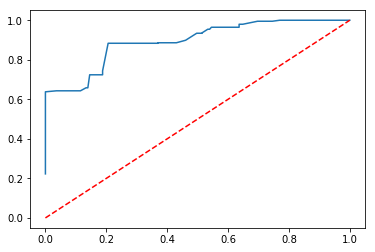

0.8940621403912542

In [67]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['nb1'])

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(features[train], full_data[train]['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [69]:
full_data['rf'] = rf.predict_proba(features)[:,1]

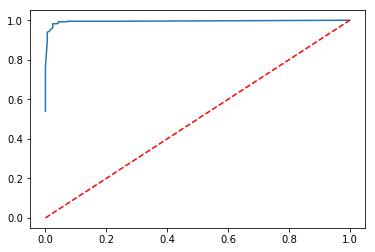

0.99474491752972771

In [70]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])

In [71]:
full_data

,address_1,address_2,match,prob,nb1,rf
0,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180 AVE,True,0.933,0.993,1.000
1,"#1195, 98141 NE 180 AVE",BLDG 1195 - 98141 NE 180th AVE,True,0.987,0.987,1.000
2,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180 AVE,True,0.933,0.993,1.000
3,"#1195, 98141 NE 180 AVE",BLDG 1195-98141 NE 180th AVE,True,0.987,0.987,1.000
4,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180 AVE",True,0.933,0.993,1.000
5,"#1195, 98141 NE 180 AVE","BLDG 1195, 98141 NE 180th AVE",True,0.987,0.987,1.000
6,"#1195, 98141 NE 180 AVE","98141 NE 180 AVE, BLDG 1195",True,0.933,0.993,1.000
7,"#1195, 98141 NE 180 AVE","98141 NE 180th AVE, BLDG 1195",True,0.987,0.987,1.000
8,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180 AVE,True,0.354,0.128,1.000
9,"#1195, 98141 NE 180 AVE",1195 - 98141 NE 180th AVE,True,0.752,0.078,1.000


In [72]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
fpr_nb, tpr_nb, thresh_nb = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
fpr_rf, tpr_rf, thresh_rf = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])

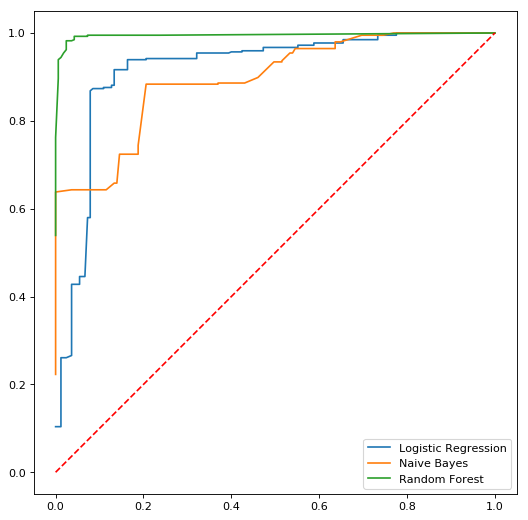

In [73]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])
roc_logit = plt.plot(fpr_logit, tpr_logit, label='Logistic Regression')
roc_naive_bayes = plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
roc_rf = plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.plot([0, 1], [0, 1],'r--')
plt.axes().set_aspect("equal")
legend()

In [74]:
final_rf = RandomForestClassifier()
final_rf.fit(X = features, y = full_data['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [75]:
import pickle
with open('address_compare/trained_models/random_forest_1', 'wb') as f:
    pickle.dump(final_rf, f)

In [46]:
from sklearn.metrics import classification_report
classification_report(full_data[~train]['match'], full_data[~train]['rf'])

ValueError: Mix type of y not allowed, got types {'continuous', 'binary'}